In [1]:
"""" 
aggregate GFS data (which is used to force RTOFS) under smb://mule/disk3/projects/tc2022/
named like:
    /mule/tc2022/GFS/sfc/[YYYYMMDD]/reg
    /mule/tc2022/tc2023/GFS/sfc/[YYYYMMDD]/reg/
    /mule/tc2022/tc2024/GFS/sfc/[YYYYMMDD]/reg/
with names like gfs.20230916.t00z.sfcf001.nc, where, in this case, 
t00z signifies the 0z forcast cycle and sfcf001 means that this data from forecast hour 1. 

to produce hourly momentum flux and surface ocean current data that offers
a chance to evaluate wind work on currents at the GFS and RTOFS horizontal scales 
(~ 12km for GFS/ 0.117 deg)(~8 km for RTFS/ 0.08 deg)

"""
''' This is for North Atlantic domain in hurricane season: 
On Mule tc2022/tc2023 directory: Both GFS & RTOFS have data range between 102W-30W, 7.5-46N. 
In 2023,    GFS has data between 8/1-11/20 (missing 9/2, 9/3). Wind data does not need bandpass filtering later
            RTOFS has data between 7/26-11/21 (missing 8/21, 9/2-9/4, 11/5)
--> That is, we have both GFS & RTOFS for wind power calculation between 
            (1) 8/1-8/19
            (2) 8/21-8/31
            (3) 9/4-11/4
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys

In [2]:
path = '/Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/'
year = '2023'
# print(np.sort( os.listdir(path) ))
# datelim = [datetime.datetime(int(year),8,1), datetime.datetime(int(year),8,31)]
# datelim = [datetime.datetime(int(year),9,1), datetime.datetime(int(year),9,30)]
# datelim = [datetime.datetime(int(year),10,1), datetime.datetime(int(year),10,31)]
datelim = [datetime.datetime(int(year),11,1), datetime.datetime(int(year),11,20)]
nfiles = (datelim[1]-datelim[0]).days+1
print('How many days are we looking to aggregate?',nfiles,'days')
file_dates = [(datelim[0]+datetime.timedelta(hours=6*i)) for i in range(nfiles*4)]
print('Looking at the following forecast cycles:\n',file_dates)
hr_fcst = np.arange(1,7) # we use the forecast hour (lead time) 1 to 6 for each forecast cycle/ initial time. 
print('For each forecast cycle, we will aggregate the following lead times:',hr_fcst)

How many days are we looking to aggregate? 20 days
Looking at the following forecast cycles:
 [datetime.datetime(2023, 11, 1, 0, 0), datetime.datetime(2023, 11, 1, 6, 0), datetime.datetime(2023, 11, 1, 12, 0), datetime.datetime(2023, 11, 1, 18, 0), datetime.datetime(2023, 11, 2, 0, 0), datetime.datetime(2023, 11, 2, 6, 0), datetime.datetime(2023, 11, 2, 12, 0), datetime.datetime(2023, 11, 2, 18, 0), datetime.datetime(2023, 11, 3, 0, 0), datetime.datetime(2023, 11, 3, 6, 0), datetime.datetime(2023, 11, 3, 12, 0), datetime.datetime(2023, 11, 3, 18, 0), datetime.datetime(2023, 11, 4, 0, 0), datetime.datetime(2023, 11, 4, 6, 0), datetime.datetime(2023, 11, 4, 12, 0), datetime.datetime(2023, 11, 4, 18, 0), datetime.datetime(2023, 11, 5, 0, 0), datetime.datetime(2023, 11, 5, 6, 0), datetime.datetime(2023, 11, 5, 12, 0), datetime.datetime(2023, 11, 5, 18, 0), datetime.datetime(2023, 11, 6, 0, 0), datetime.datetime(2023, 11, 6, 6, 0), datetime.datetime(2023, 11, 6, 12, 0), datetime.datetime(20

In [3]:
''' Read one file a time to aggregate selected variables of interest'''
str_vars = ['TIME','LON','LAT','UFLX_AVE','VFLX_AVE']
vars_nostack = ['LON','LAT']
''' Cread Dictionary'''
vars_dic = {}
vars_dic_attr = {}
attr = ['long_name','units']#,'_FillValue'] # attributes names of interest (to be included in the output file)
ds = nc.Dataset( path+'20230907/reg/gfs.20230907.t00z.sfcf001.nc')
varnms = list( ds.variables.keys() )
print(varnms)
''' add empty items to the dictionary '''
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey in str_vars:
        print(vkey)
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        attrnms = ds.variables[vkey].ncattrs()
        # print(attrnms)
        ### record attributes
        for a in range( len(attr) ):
            # ds.variables[vkey].units
            if attr[a] in attrnms:
                print(attr[a])
                str_eval = "ds.variables['" + vkey + "']." + attr[a]
                vars_dic_attr[vkey+'-'+attr[a]] = eval(str_eval)
                print(str_eval)
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')

['GRID_XT2203_2817', 'GRID_YT833_1161', 'GRID_YT833_1161_bnds', 'LAT', 'LON', 'TIME', 'DLWRF', 'DLWRF_AVE', 'DSWRF', 'DSWRF_AVE', 'FRICV', 'HPBL', 'LHTFL', 'LHTFL_AVE', 'PRESSFC', 'SFCR', 'SHTFL', 'SHTFL_AVE', 'SPFH2M', 'SPFH_HYBLEV1', 'SPFHMAX_MAX2M', 'SPFHMIN_MIN2M', 'TMAX_MAX2M', 'TMIN_MIN2M', 'TMP2M', 'TMP_HYBLEV1', 'TMPSFC', 'TPRCP', 'UFLX_AVE', 'UGRD10M', 'UGRD_HYBLEV1', 'ULWRF', 'ULWRF_AVE', 'USWRF', 'USWRF_AVE', 'VFLX_AVE', 'VGRD10M', 'VGRD_HYBLEV1']
LAT
long_name
ds.variables['LAT'].long_name
units
ds.variables['LAT'].units
LON
long_name
ds.variables['LON'].long_name
units
ds.variables['LON'].units
TIME
long_name
ds.variables['TIME'].long_name
units
ds.variables['TIME'].units
UFLX_AVE
long_name
ds.variables['UFLX_AVE'].long_name
units
ds.variables['UFLX_AVE'].units
VFLX_AVE
long_name
ds.variables['VFLX_AVE'].long_name
units
ds.variables['VFLX_AVE'].units
38 variables in nc file & 5 variables are selected to append


In [4]:
### Go through the folders listed above and use the forecast hour 1-6 for each forecast cycle
cnt = 0
# dtime_base = datetime.datetime(int(year),1,1)
for f, dtime_f in enumerate(file_dates):
    folder_date = dtime_f.strftime('%Y%m%d')
    fcst_cycle_hr = dtime_f.hour # should be called forecast cycle hour or initial time
    print('datetime of forecast cycle:',dtime_f, 'date:',folder_date, 'forcast cycle hour:',str(fcst_cycle_hr).zfill(2), )
    for hr in hr_fcst: # this is forecast hour or lead time after each forecast cycle.
        path_fn = path+folder_date+'/reg/gfs.'+folder_date+\
            '.t'+str(fcst_cycle_hr).zfill(2)+'z.sfcf'+str(hr).zfill(3)+'.nc'
        ''' check if file exist '''
        if os.path.isfile(path_fn):
            ds = nc.Dataset(path_fn)
            for i in range( len(varnms) ):
                vkey = varnms[i]
                if (vkey in str_vars) & (vkey not in vars_nostack):
                    # print(vkey)
                    vkey = varnms[i]
                    item_old = vars_dic[vkey]
                    if vkey == 'TIME':
                        # item_app = np.array([(datetime.datetime.strptime(folder_date,'%Y%m%d')+\
                        #         datetime.timedelta(hours=int(fcst_cycle_hr+hr))-dtime_base).total_seconds()])
                        item_app = np.array([(datetime.datetime.strptime(folder_date,'%Y%m%d')+\
                                datetime.timedelta(hours=int(fcst_cycle_hr+hr))).timestamp()])
                        # print([datetime.datetime.fromtimestamp(item) for item in item_app])
                    else:
                        item_app = ds.variables[vkey][:]
                    ### append in time dimension only
                    if cnt == 0:
                        vars_dic[vkey] = item_app
                    else:
                        vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
                    if cnt == 0: ### for variables that do not need to append in time
                        for var_nostack in vars_nostack:
                            vars_dic[var_nostack] = ds.variables[var_nostack][:]
            ds.close()
            print('Done',path_fn)
            cnt = cnt + 1
        else:
            print(path_fn,'does not exist.')
    # break

datetime of forecast cycle: 2023-11-01 00:00:00 date: 20231101 forcast cycle hour: 00
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t00z.sfcf001.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t00z.sfcf002.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t00z.sfcf003.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t00z.sfcf004.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t00z.sfcf005.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t00z.sfcf006.nc
datetime of forecast cycle: 2023-11-01 06:00:00 date: 20231101 forcast cycle hour: 06
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t06z.sfcf001.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t06z.sfcf002.nc
Done /Volumes/disk3/projects/tc2022/tc2023/GFS/sfc/20231101/reg/gfs.20231101.t06z.sf

2023-11-01 01:00:00 2023-11-21 00:00:00


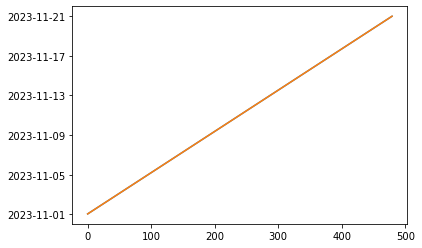

In [5]:
dtime = np.array([datetime.datetime.fromtimestamp(item) for item in vars_dic['TIME']])
time_out = vars_dic['TIME']
plt.plot(dtime)
plt.plot(dtime)
print(dtime[0],dtime[-1])

In [6]:
''' Write merged GFS data to netcdf file'''
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfname_out = 'GFS.merge.sfc.'+datelim[0].strftime('%Y%m%d')+'-'+datelim[-1].strftime('%Y%m%d')+'.nc'
print('Creating a new file:',ncfname_out)
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime)) # unlimited axis (can be appended to).
lon_dim = ncfile.createDimension('longitude', vars_dic['UFLX_AVE'].shape[2])
lat_dim = ncfile.createDimension('latitude', vars_dic['UFLX_AVE'].shape[1])
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for GFS sfc data between '+dtime[0].strftime('%Y%m%d %HZ')+\
    ' and '+dtime[-1].strftime('%Y%m%d %HZ')+'\n'\
    +'Here the forecast hour 1 ~ 6 is aggregated for each forecast cycle (6 hour) for a hourly time series.'
print(ncfile.title)
ncfile.subtitle="Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution."
print(ncfile.subtitle)
print(ncfile)

Creating a new file: GFS.merge.sfc.20231101-20231120.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 480)
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 615)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 329)
Merged files for GFS sfc data between 20231101 01Z and 20231121 00Z
Here the forecast hour 1 ~ 6 is aggregated for each forecast cycle (6 hour) for a hourly time series.
Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20231101 01Z and 20231121 00Z
Here the forecast hour 1 ~ 6 is aggregated for each forecast cycle (6 hour) for a hourly time serie

In [7]:
### Creating variables
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds that have elapsed since epoch - 1971/01/01'
time.long_name = 'timestamp'
vars_names = ['LON','LAT','UFLX_AVE','VFLX_AVE']
### 2: (Y, X) 3: (time, Y, X)
dim_cat = [2,2,3,3]
for i, var_name in enumerate(vars_names):
    print(var_name)
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 2:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + "', np.float64, ('" + 'latitude' + "','"+ 'longitude' +"'))"
    elif dim_cat[i] == 3:
        str_exec = var_name + "= ncfile.createVariable('" + var_name + \
                    "', np.float64, ('" + 'time' + "','"+ 'latitude' + "','" + 'longitude' +"'))"
    exec(str_exec)
    print(i,str_exec)
    ### add attributes
attr_keys = vars_dic_attr.keys()
str_no = ['TIME']
for attr_key in attr_keys:
    i_ = attr_key.find('-')
    if attr_key[:i_] not in str_no:
        str_exec = attr_key.replace('-','.') + " = '"+ str(vars_dic_attr[attr_key]) + "'"
        exec(str_exec)

LON
0 LON= ncfile.createVariable('LON', np.float64, ('latitude','longitude'))
LAT
1 LAT= ncfile.createVariable('LAT', np.float64, ('latitude','longitude'))
UFLX_AVE
2 UFLX_AVE= ncfile.createVariable('UFLX_AVE', np.float64, ('time','latitude','longitude'))
VFLX_AVE
3 VFLX_AVE= ncfile.createVariable('VFLX_AVE', np.float64, ('time','latitude','longitude'))


In [8]:
### writing data
# Note: the ":" is necessary in these "write" statements
time[:] = time_out
for i, var_name in enumerate(vars_names):
    if dim_cat[i] == 2:
        str_exec = var_name + "[:,:]= vars_dic['" + var_name + "']"
    elif dim_cat[i] == 3:
        str_exec = var_name + "[:,:,:]= vars_dic['" + var_name + "']"
    exec(str_exec)
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20231101 01Z and 20231121 00Z
Here the forecast hour 1 ~ 6 is aggregated for each forecast cycle (6 hour) for a hourly time series.
    subtitle: Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
    dimensions(sizes): time(480), longitude(615), latitude(329)
    variables(dimensions): float64 time(time), float64 LON(latitude, longitude), float64 LAT(latitude, longitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude)
    groups: 
Dataset is closed!
